## Rotulagem dos dados

Este notebook tem por objetivo rotular os comentários do YouTube do canal Lion BBQ. Foi utilizado o modelo KMeans para pré rotular os dados e com isso gerar uma base de treino para o modelo de classificação.

In [1]:
! pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import stop_words
from wordcloud import WordCloud
from operator import itemgetter

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

In [4]:
folder = 'lion_bbq'
file = f'data_full_{folder}.csv'

In [5]:
df = pd.read_csv(f'data_full_{folder}.csv')

In [6]:
df = df[['video_title', 
         'author', 
         'comment', 
         'comment_cleaned', 
         'comment_stop_word', 
         'comment_tokenized', 
         'comment_stemming',
         'comment_lematized']]

In [7]:
df['category'] = 'Outro'
df = df[df['author'].notna()]
df.shape

(2361, 9)

In [8]:
df.head()

,video_title,author,comment,comment_cleaned,comment_stop_word,comment_tokenized,comment_stemming,comment_lematized,category
0,coments_of_Mini Festival Lion BBQ,Oscar Polatto,"Mini?? Se junta um pouco mais de gente, leva nome de casamento kkkkkk",mini?? se junta um pouco mais de gente leva nome de casamento kkkkkk,mini?? junta pouco gente leva nome casamento kkkkkk,"['mini', '?', '?', 'junta', 'pouco', 'gente', 'leva', 'nome', 'casamento', 'kkkkkk']","['min', '?', '?', 'junt', 'pouc', 'gent', 'lev', 'nom', 'casament', 'kkkkkk']","['mini', '?', '?', 'junta', 'pouco', 'gente', 'lev', 'nome', 'casamento', 'kkkkkk']",Outro
1,coments_of_Mini Festival Lion BBQ,José Roberto de Oliveira,"Que Deus abençoe sempre a sua família!!! Parabéns pelo belo trabalho!!! Mais uma coisa, deu água na boca... kkkkkk",que deus abencoe sempre a sua familia parabens pelo belo trabalho mais uma coisa deu agua na boca kkkkkk,deus abencoe sempre familia parabens belo trabalho coisa deu agua boca kkkkkk,"['deus', 'abencoe', 'sempre', 'familia', 'parabens', 'belo', 'trabalho', 'coisa', 'deu', 'agua', 'boca', 'kkkkkk']","['deus', 'abenco', 'sempr', 'famil', 'parabens', 'bel', 'trabalh', 'cois', 'deu', 'agu', 'boc', 'kkkkkk']","['deus', 'abencoe', 'sempre', 'familia', 'parabens', 'belo', 'trabalho', 'coisa', 'deu', 'agua', 'boca', 'kkkkkk']",Outro
2,coments_of_Mini Festival Lion BBQ,Adriano Queiroz,Qualé Manollo!!! Abre pros de fora entrar!!!😂😂😂😂❤🖤🤘🤘 PARABÉNS!!!,quale manollo abre pros de fora entrar parabens,quale manollo abre pros entrar parabens,"['quale', 'manollo', 'abre', 'pros', 'entrar', 'parabens']","['qual', 'manoll', 'abre', 'pros', 'entrar', 'parabens']","['quale', 'manollo', 'abre', 'pro', 'entrar', 'parabens']",Outro
3,coments_of_Mini Festival Lion BBQ,VALDECIR Balduino,"Léo! Nosso Manolo, você arrebentou 🤘 e que bom que não esqueceu da hidratação. 🤣",leo nosso manolo voce arrebentou e que bom que nao esqueceu da hidratacao,leo manolo voce arrebentou bom nao esqueceu hidratacao,"['leo', 'manolo', 'voce', 'arrebentou', 'bom', 'nao', 'esqueceu', 'hidratacao']","['leo', 'manol', 'voc', 'arrebent', 'bom', 'nao', 'esquec', 'hidrataca']","['leo', 'manolo', 'voce', 'arrebentou', 'bom', 'nao', 'esqueceu', 'hidratacao']",Outro
4,coments_of_Mini Festival Lion BBQ,Paulinha Tamiê,CARAMBA MEUS AMIGOS QUE ORGULHO DE VCS! QUE MÁXIMO ESSE FESTIVAL! PENA NÃO TER DADO PRA IRMOS NESSA MAS NÃO FALTARÃO OPORTUNIDADES! VCS SABEM QUE VCS SÃO NOSSA FAMÍLIA E SÓ DESEJAMOS MUITO SUCESSO!!!!!! AMAMOS VCS 🥰,caramba meus amigos que orgulho de vcs que maximo esse festival pena nao ter dado pra irmos nessa mas nao faltarao oportunidades vcs sabem que vcs sao nossa familia e so desejamos muito sucesso amamos vcs,caramba amigos orgulho vcs maximo festival pena nao ter dado pra irmos nessa nao faltarao oportunidades vcs sabem vcs sao familia so desejamos sucesso amamos vcs,"['caramba', 'amigos', 'orgulho', 'vcs', 'maximo', 'festival', 'pena', 'nao', 'ter', 'dado', 'pra', 'irmos', 'nessa', 'nao', 'faltarao', 'oportunidades', 'vcs', 'sabem', 'vcs', 'sao', 'familia', 'so', 'desejamos', 'sucesso', 'amamos', 'vcs']","['caramb', 'amig', 'orgulh', 'vcs', 'maxim', 'festival', 'pen', 'nao', 'ter', 'dad', 'pra', 'irmos', 'ness', 'nao', 'faltara', 'oportun', 'vcs', 'sab', 'vcs', 'sao', 'famil', 'so', 'desej', 'sucess', 'amam', 'vcs']","['caramba', 'amigo', 'orgulho', 'vcs', 'maximo', 'festival', 'pena', 'nao', 'ter', 'dado', 'pra', 'irmos', 'nessa', 'nao', 'faltarao', 'oportunidades', 'vcs', 'sabem', 'vcs', 'sao', 'familia', 'so', 'desejamos', 'sucesso', 'amamos', 'vcs']",Outro


## Função de agrupamento

In [9]:
def pooler(documents, iters, min_df=5, max_df=0.7, ngram=(1, 3), max_features=1000):
    # documents vectorizer
    vectorizer = TfidfVectorizer(
        min_df=min_df,
        max_df=max_df,
        ngram_range=ngram,
        max_features=max_features
    ).fit(documents)
    vectorized = vectorizer.transform(documents)
    
    # pooler model
    sse = []
    models = []
    for k in iters:
        model = MiniBatchKMeans(n_clusters=k, init_size=256, batch_size=512, random_state=42).fit(vectorized)
        models.append(model)
        sse.append(model.inertia_)
        model.predict(vectorized)
        
    return models, sse, vectorized, vectorizer.get_feature_names()

def get_model(models, k):
    c = ((k - 2) // 2)
    return models[c]

## Avaliando agrupamento

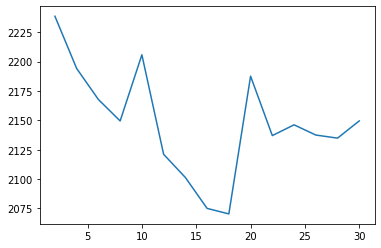

In [14]:
iters = range(2, 30 + 1, 2)
models, sse, vectorized, vocabulary = pooler(df.comment_stemming.values, iters, min_df=5, max_df=0.6, max_features=1500)

plt.plot(iters, sse)
plt.show()

## Agrupando comentários

In [15]:
k = 18
model = get_model(models, k)
model.predict(vectorized)

df['cluster'] = model.predict(vectorized)
df.head()

,video_title,author,comment,comment_cleaned,comment_stop_word,comment_tokenized,comment_stemming,comment_lematized,category,cluster
0,coments_of_Mini Festival Lion BBQ,Oscar Polatto,"Mini?? Se junta um pouco mais de gente, leva nome de casamento kkkkkk",mini?? se junta um pouco mais de gente leva nome de casamento kkkkkk,mini?? junta pouco gente leva nome casamento kkkkkk,"['mini', '?', '?', 'junta', 'pouco', 'gente', 'leva', 'nome', 'casamento', 'kkkkkk']","['min', '?', '?', 'junt', 'pouc', 'gent', 'lev', 'nom', 'casament', 'kkkkkk']","['mini', '?', '?', 'junta', 'pouco', 'gente', 'lev', 'nome', 'casamento', 'kkkkkk']",Outro,6
1,coments_of_Mini Festival Lion BBQ,José Roberto de Oliveira,"Que Deus abençoe sempre a sua família!!! Parabéns pelo belo trabalho!!! Mais uma coisa, deu água na boca... kkkkkk",que deus abencoe sempre a sua familia parabens pelo belo trabalho mais uma coisa deu agua na boca kkkkkk,deus abencoe sempre familia parabens belo trabalho coisa deu agua boca kkkkkk,"['deus', 'abencoe', 'sempre', 'familia', 'parabens', 'belo', 'trabalho', 'coisa', 'deu', 'agua', 'boca', 'kkkkkk']","['deus', 'abenco', 'sempr', 'famil', 'parabens', 'bel', 'trabalh', 'cois', 'deu', 'agu', 'boc', 'kkkkkk']","['deus', 'abencoe', 'sempre', 'familia', 'parabens', 'belo', 'trabalho', 'coisa', 'deu', 'agua', 'boca', 'kkkkkk']",Outro,14
2,coments_of_Mini Festival Lion BBQ,Adriano Queiroz,Qualé Manollo!!! Abre pros de fora entrar!!!😂😂😂😂❤🖤🤘🤘 PARABÉNS!!!,quale manollo abre pros de fora entrar parabens,quale manollo abre pros entrar parabens,"['quale', 'manollo', 'abre', 'pros', 'entrar', 'parabens']","['qual', 'manoll', 'abre', 'pros', 'entrar', 'parabens']","['quale', 'manollo', 'abre', 'pro', 'entrar', 'parabens']",Outro,13
3,coments_of_Mini Festival Lion BBQ,VALDECIR Balduino,"Léo! Nosso Manolo, você arrebentou 🤘 e que bom que não esqueceu da hidratação. 🤣",leo nosso manolo voce arrebentou e que bom que nao esqueceu da hidratacao,leo manolo voce arrebentou bom nao esqueceu hidratacao,"['leo', 'manolo', 'voce', 'arrebentou', 'bom', 'nao', 'esqueceu', 'hidratacao']","['leo', 'manol', 'voc', 'arrebent', 'bom', 'nao', 'esquec', 'hidrataca']","['leo', 'manolo', 'voce', 'arrebentou', 'bom', 'nao', 'esqueceu', 'hidratacao']",Outro,3
4,coments_of_Mini Festival Lion BBQ,Paulinha Tamiê,CARAMBA MEUS AMIGOS QUE ORGULHO DE VCS! QUE MÁXIMO ESSE FESTIVAL! PENA NÃO TER DADO PRA IRMOS NESSA MAS NÃO FALTARÃO OPORTUNIDADES! VCS SABEM QUE VCS SÃO NOSSA FAMÍLIA E SÓ DESEJAMOS MUITO SUCESSO!!!!!! AMAMOS VCS 🥰,caramba meus amigos que orgulho de vcs que maximo esse festival pena nao ter dado pra irmos nessa mas nao faltarao oportunidades vcs sabem que vcs sao nossa familia e so desejamos muito sucesso amamos vcs,caramba amigos orgulho vcs maximo festival pena nao ter dado pra irmos nessa nao faltarao oportunidades vcs sabem vcs sao familia so desejamos sucesso amamos vcs,"['caramba', 'amigos', 'orgulho', 'vcs', 'maximo', 'festival', 'pena', 'nao', 'ter', 'dado', 'pra', 'irmos', 'nessa', 'nao', 'faltarao', 'oportunidades', 'vcs', 'sabem', 'vcs', 'sao', 'familia', 'so', 'desejamos', 'sucesso', 'amamos', 'vcs']","['caramb', 'amig', 'orgulh', 'vcs', 'maxim', 'festival', 'pen', 'nao', 'ter', 'dad', 'pra', 'irmos', 'ness', 'nao', 'faltara', 'oportun', 'vcs', 'sab', 'vcs', 'sao', 'famil', 'so', 'desej', 'sucess', 'amam', 'vcs']","['caramba', 'amigo', 'orgulho', 'vcs', 'maximo', 'festival', 'pena', 'nao', 'ter', 'dado', 'pra', 'irmos', 'nessa', 'nao', 'faltarao', 'oportunidades', 'vcs', 'sabem', 'vcs', 'sao', 'familia', 'so', 'desejamos', 'sucesso', 'amamos', 'vcs']",Outro,6


## Nuvem de palavras

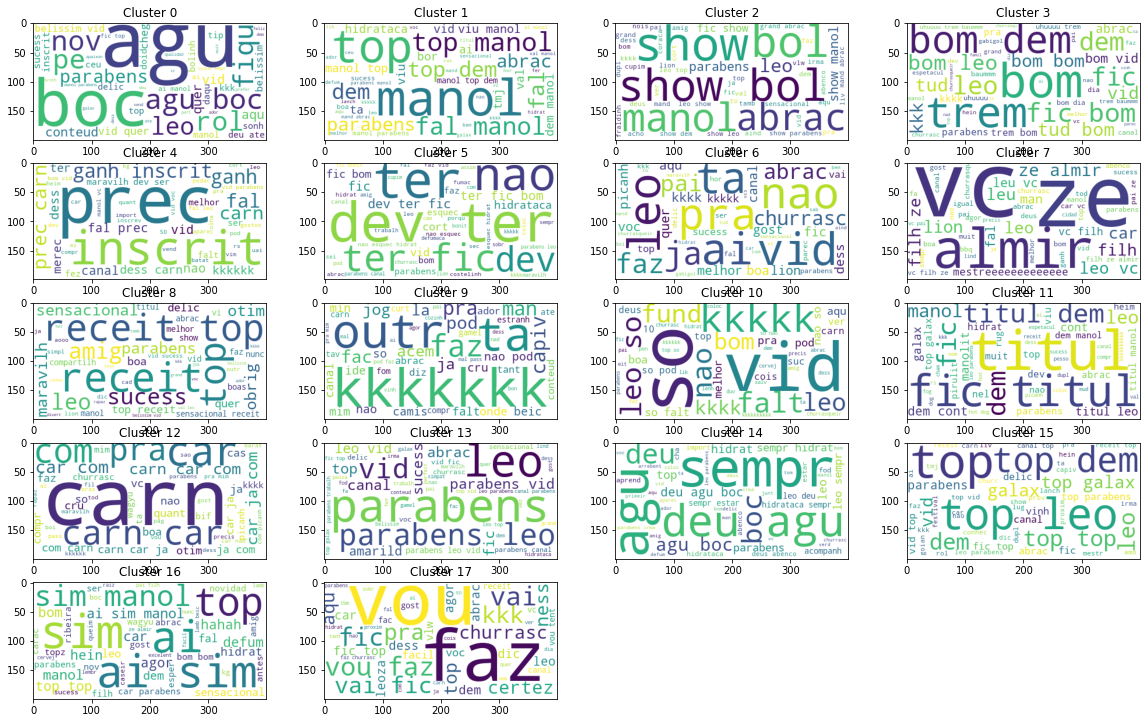

In [16]:
mw = 50

fig = plt.figure(figsize = (20, 15))
vocabulary.append('')

i = 0
for r in model.cluster_centers_:
    dictionary = { vocabulary[k]: r[k] for k in np.argsort(r)[::-1][:mw] }
    dictionary = {k: v for k, v in dictionary.items() if v > 0}

    wc = WordCloud(background_color='white', max_words=mw, relative_scaling=0.1, normalize_plurals=True)
    image = wc.generate_from_frequencies(dictionary)

    ax = fig.add_subplot(6, 4, (i + 1))
    plt.imshow(image)
    ax.set_title(f'Cluster {i}')
    i = i + 1

## Melhores exemplos

In [17]:
def sort_best_binds(key):
    # calculate similarities
    similarities = []
    centroid = model.cluster_centers_[key]
    for v in vectorized:
        similarities.append(cosine_similarity([centroid], v))

    # best binds
    indexes = np.array([s[0][0] for s in similarities])
    indexes = np.argsort(indexes)[::-1]
    
    return indexes

## Top N exemplos

In [18]:
topn = 15

for i in range(len(model.cluster_centers_)):
    indexes = sort_best_binds(i)
    values = df.iloc[indexes[:topn]].comment_stop_word.values
    print(f'\nCluster: {i}')
    for v in range(topn):
        print(values[v][:200])


Cluster: 0
fiquei agua boca
cara fiquei agua boca manolo
parabens ficou top agua boca aqui
leo passa endereco dessa casa botelhos fiquei agua boca
deu ate agua boca
fiquei agua boca daqui bolinho sonhos
eiitaaaa deu agua boca leo
deliciaaaa aguei
hummmm boca encheu d'agua panceta rodizio leo?
hum deu agua boca q
deu agua boca? delicia
parabens video dar agua boca sorte q perto
parabens querido video lanches sao esses? deu ate agua boca
video ta bao demais deu agua boca
adoro lanche deu agua boca

Cluster: 1
visao paraiso manolo
daora manolo
top manolo
top manolo
top manolo
top manolo
top manolo
top manolo qui isooooo abraco
manolo henieken ta patrocinando
manolo judiacao top demais
nivel manolo top
manolo show video
adoro espontaneidade bj manolo
hidratacao manolo
fala manolo ta nervoso vai pescar kkk bom manolo

Cluster: 2
show
show
show
show
show
show
show
show
show
show
show bola
show bola
parabens show bola
show bola leonel bom
manolo show video

Cluster: 3
bom
bom
bom
bom
bom
aoo


Cluster: 13
parabens leo
top sempre parabens leo
parabens leo toop galaxias
parabens artmilllion
parabens
quale manollo abre pros entrar parabens
showwwwww parabens
parabens leo tmj
primeiro parabens leo trampo tmjt
parabens leo top
parabens leo hidratacao tudo
parabens leo sensacional parabens artesao video ficou show
top receita parabens leo
parabens leo carne maravilhosa top video conteudo agradavel
leo babei

Cluster: 14
eiitaaaa deu agua boca leo
gratos sempre
hum deu agua boca q
deu agua boca? delicia
deus abencoe sempre familia parabens belo trabalho coisa deu agua boca kkkkkk
sempre top
adoro lanche deu agua boca
fera leo deu agua boca
ficou titula deu agua boca
video ta bao demais deu agua boca
legal defumadora carne deu agua boca
ficou divino parabens adoro salmao deu agua boca
receita top leo deu agua boca
like garantindo antes assistir deu agua boca
bolinho deu agua boca ficou titula leo parabens

Cluster: 15
top
top irmaooo
top
top feraaaaaaa
top
top
top
top
top
top d++++

## Categorias

In [19]:
maps = {
    0: 'água na boca',
    1: 'bordão',
    2: 'elogio',
    3: 'desconhecido',
    4: 'duvida',
    5: 'elogio',
    6: 'desconhecido',
    7: 'José Almiro',
    8: 'elogio',
    9: 'desconhecido',
    10: 'desconhecido',
    11: 'bordão',
    12: 'crítica',
    13: 'elogio',
    14: 'água na boca',
    15: 'elogio',
    16: 'elogio',
    17: 'vou fazer'}

## Categorizar agrupamento

In [20]:
top_binds = 50

for key in maps:
    if maps[key]:
        
        # best binds
        indexes = sort_best_binds(key)

        # labeling records
        df['category'].iloc[indexes[:top_binds]] = maps[key]
        df.groupby(['category'])['author'].count()

/home/guilherme.gomes/.local/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/guilherme.gomes/.local/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/guilherme.gomes/.local/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._se

In [21]:
df.groupby(['category'])['author'].count().sort_values(ascending=False)

category
Outro           1574
elogio          278 
desconhecido    170 
bordão          84  
água na boca    67  
vou fazer       50  
José Almiro     50  
crítica         48  
duvida          40  
Name: author, dtype: int64

In [22]:
df[~df['category'].isin(['Outro'])].to_csv('croresid_labeled.csv', sep=',', encoding='utf-8', index=False)